In [75]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
import numpy as np
import scipy

In [77]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as font_manager
from mpl_toolkits.mplot3d import axes3d

mpl.rcParams['font.family']='serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False
mpl.rcParams['figure.dpi'] = 300
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams.update({'font.size': 18})

In [78]:
from sample_3d_view import sample_sphere, sample_torus, visualize_grid_sphere, visualize_grid_torus, sample_ellipsoid

In [79]:
from local_pca_utils import make_nearest_neighbors_graph, make_tangents, make_2nd_order_laplacian,make_general_order_laplacian, make_connection

from curvature_utils import make_tangents_and_normals, get_second_fundamental_form

from tensorlaplacian_utils import get_riemannian_ricci_scalar, get_weitzenbock_operator, get_eigvals_of_weitzenbock, weitzenbock_to_bsr

In [303]:
npoints = 5000

In [304]:
data_s2 = sample_sphere(npoints)
data_s2 *= 3
s2_graph = make_nearest_neighbors_graph(data_s2, 20, n=npoints)
#s2_tangents, s2_normals, local_coords, s2triu, s2_h = get_second_fundamental_form(data_s2, s2_graph, 2)
_,_,_,_, s2_h = get_second_fundamental_form(data_s2, s2_graph, 2)

Riem, Ric, Scal = get_riemannian_ricci_scalar(s2_h)


100%|██████████| 5000/5000 [00:01<00:00, 3105.59it/s]


In [305]:
weitzenbock = get_weitzenbock_operator(Riem,2,1)
block_weitzenbock = weitzenbock_to_bsr(weitzenbock)

In [306]:
block_weitzenbock

<10000x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 20000 stored elements (blocksize = 2x2) in Block Sparse Row format>

In [307]:
tangents = make_tangents(data_s2, s2_graph, 2)

connection = make_connection(tangents, s2_graph)

s_1st_order_lap = make_general_order_laplacian(connection, s2_graph, 1, sym=False, zero_trace=False)

s_2nd_order_lap = make_2nd_order_laplacian(connection, s2_graph, sym=False, zero_trace=False)

100%|██████████| 5000/5000 [00:05<00:00, 846.90it/s]


In [308]:
lichnerowicz = -s_1st_order_lap + block_weitzenbock

In [309]:
eigvals, eigvecs = scipy.sparse.linalg.eigs(lichnerowicz, k=10, which='SM')

In [310]:
eigvals

array([-0.02696468+0.j, -0.02696468+0.j, -0.0288356 +0.j, -0.0288356 +0.j,
       -0.02987103+0.j, -0.02987103+0.j, -0.19976214+0.j, -0.19976214+0.j,
       -0.2046355 +0.j, -0.2046355 +0.j])

In [311]:
eigvecs.shape

(10000, 10)

In [312]:
eigvecs[:,0].shape

(10000,)

In [349]:
eigvector = eigvecs[:,1].real

In [350]:
eigvector

array([-0.01205189, -0.00844279,  0.0100348 , ...,  0.00046572,
       -0.00486866,  0.00272123])

In [351]:
eigvector = eigvector.reshape(-1,2)

In [352]:
eigvector

array([[-0.01205189, -0.00844279],
       [ 0.0100348 ,  0.00153915],
       [ 0.01144364, -0.00350462],
       ...,
       [-0.00335434,  0.01845309],
       [-0.00226642,  0.00046572],
       [-0.00486866,  0.00272123]])

In [353]:
tangents.shape

(5000, 2, 3)

In [354]:
eigvector.shape

(5000, 2)

In [355]:
killingfield = np.zeros((npoints, 3))

In [356]:
for i in range(npoints):
    killingfield[i] = tangents[i, 0]* eigvector[i, 0] +  tangents[i, 1]* eigvector[i, 1] 

In [357]:
killingfield.shape

(5000, 3)

In [358]:
visualizer = np.zeros((npoints, 6))

In [359]:
data_s2.shape

(5000, 3)

In [360]:
indices = np.where(np.logical_not((data_s2[:,0]<0)&(data_s2[:,1]>0)))

In [361]:
indices[0]

array([   0,    1,    2, ..., 4997, 4998, 4999])

In [362]:
indices[:20]

(array([   0,    1,    2, ..., 4997, 4998, 4999]),)

In [363]:
visualizer[:,:3] = data_s2
visualizer[:,3:] = killingfield*60

In [364]:
X, Y, Z, U, V, W = zip(*visualizer[indices[0][:700]])

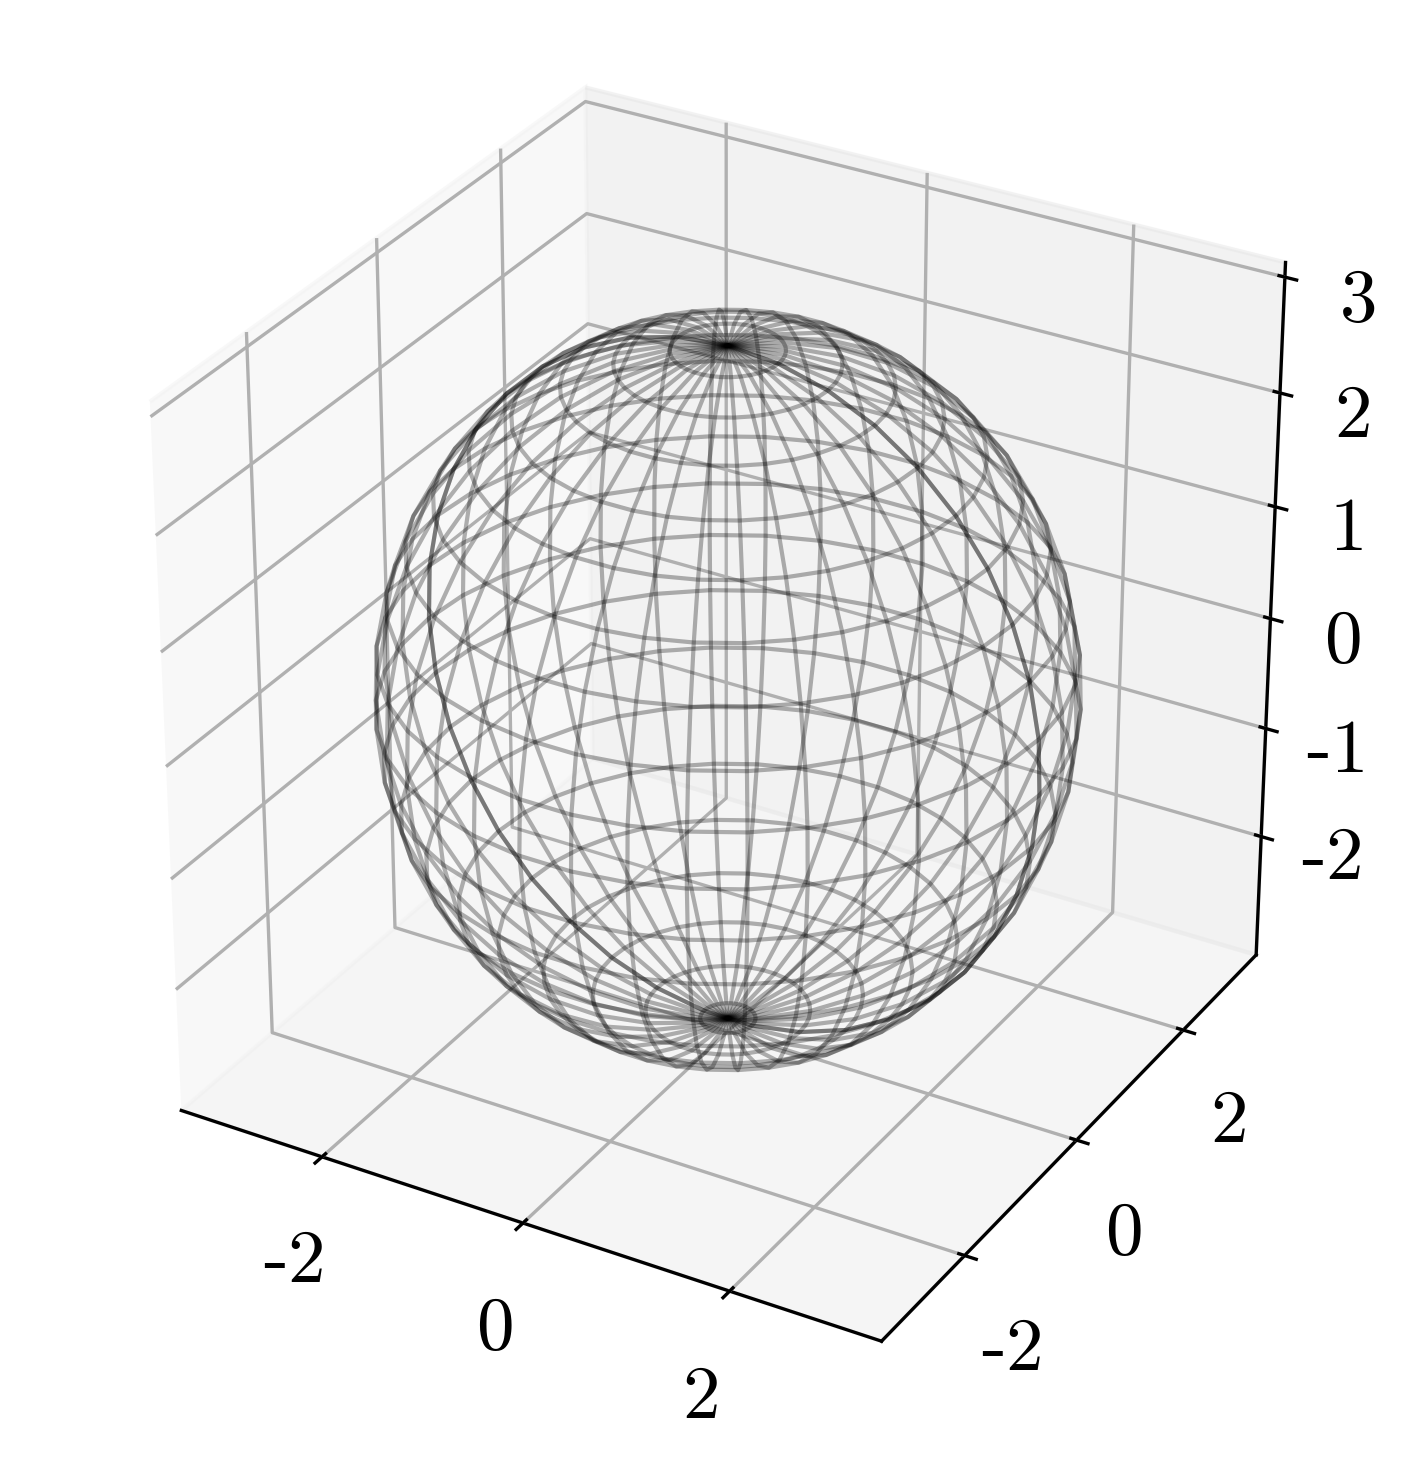

In [365]:
fig, ax = visualize_grid_sphere(3)
ax.set_box_aspect([1,1,1])

In [366]:
ax.quiver(X, Y, Z, U, V, W, color="C0", linewidth=0.7)

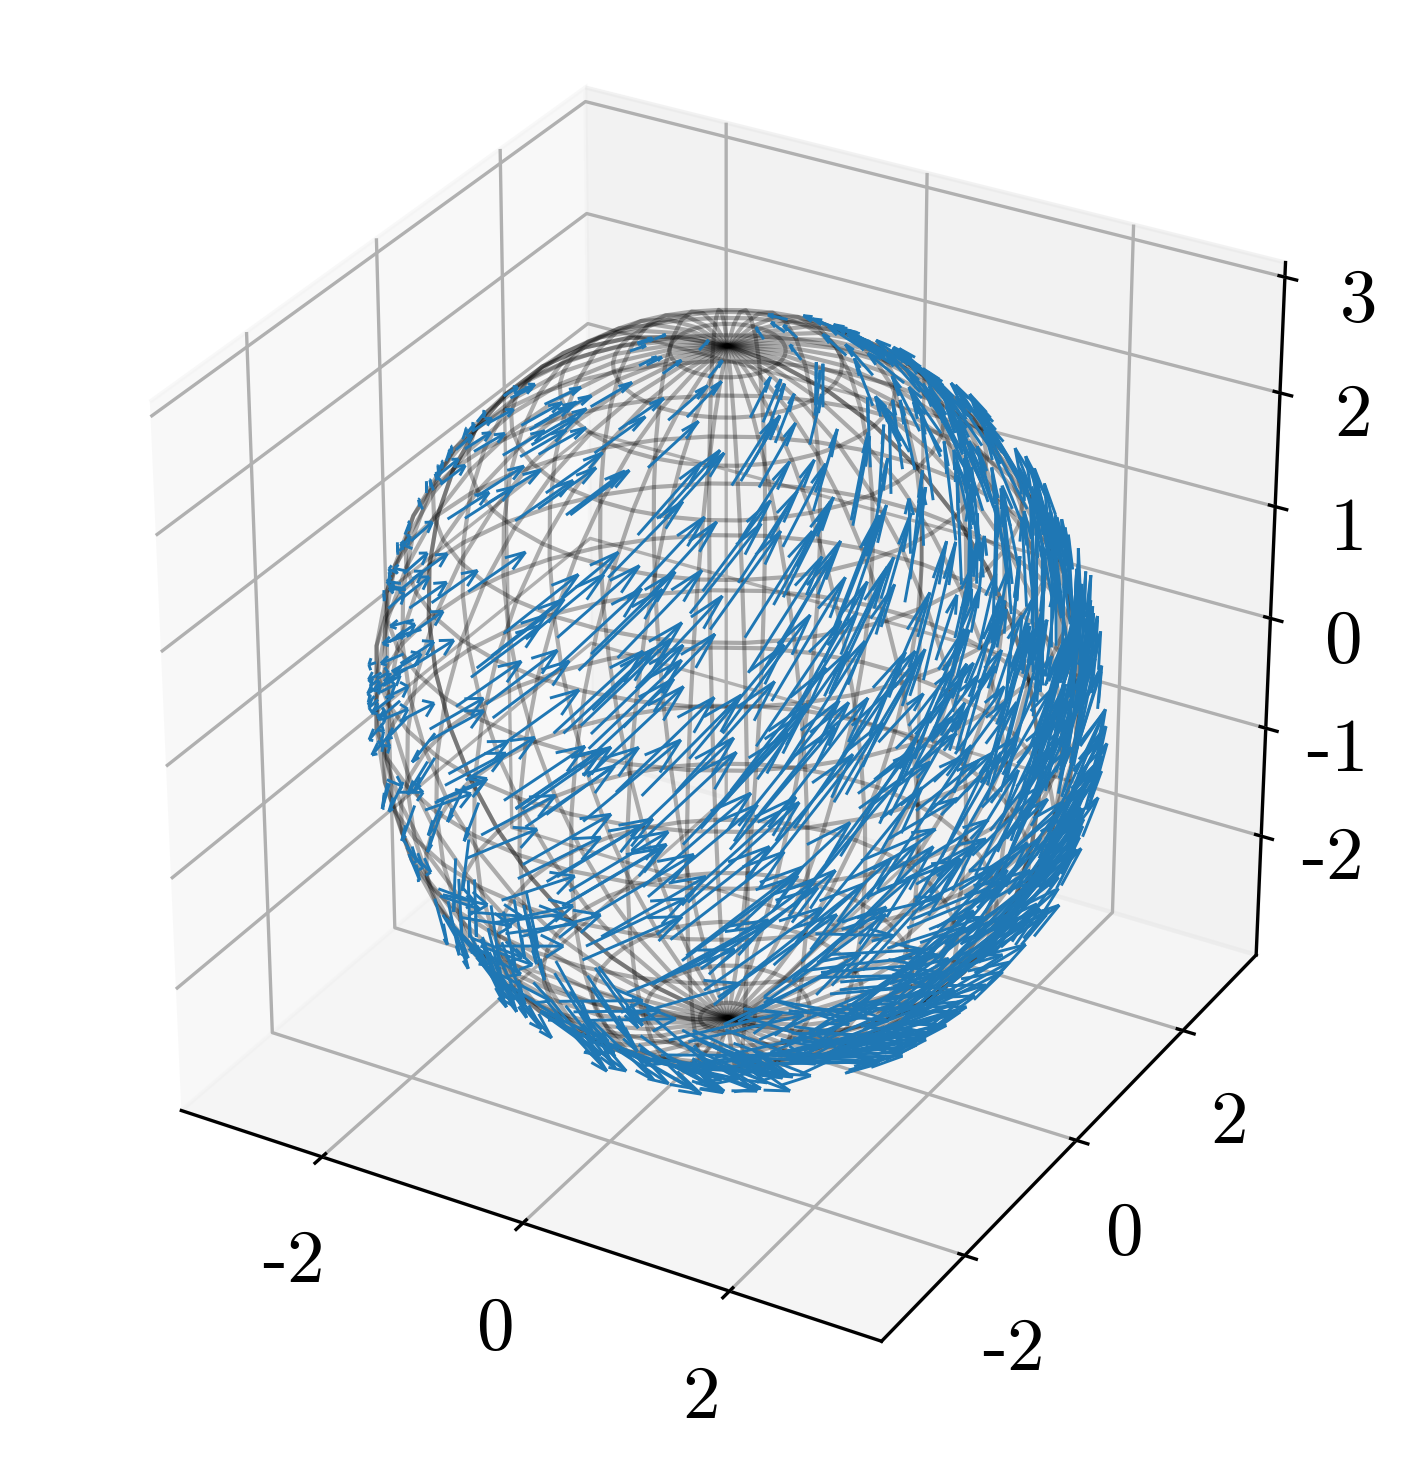

In [367]:
fig

In [368]:
fig.savefig(f'../figures/KillingField_Sphere_first.png')    
fig.savefig(f'../figures/KillingField_Sphere_first.pdf')